In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import io as spio
from tqdm import tqdm
import cv2
from sklearn import metrics


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Split Data

In [32]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ('\nElapsed time is ')
        print (str(time.time() - startTime_for_tictoc))
        print('seconds.\n')
    else:
        print ('\nToc: start time not set\n')

In [33]:
data= sio.loadmat('/Users/fernanda/Documents/Tese_Mestrado/GitHub/Plastic-Strain-Predictions/data/Sample_2/RDM_Sample_2.mat')
angles= data['RDM']['angles'][0][0]
Enn= data['RDM']['Strains'][0][0][0][0][5]
Etn= data['RDM']['Strains'][0][0][0][0][4]
Ett= data['RDM']['Strains'][0][0][0][0][3]
CM= data['RDM']['CM'][0][0]

indPred= CM==1
wndSize= 35
n,m = angles.shape

print('n=', n , 'm=', m )

stride= int((wndSize-1)/2)
ncases= sum(sum(CM[stride:n-stride,stride:m-stride]==1))

Y= np.zeros((ncases,5))
# X0= np.zeros((ncases, wndSize**2))
X0 = []
X1= np.zeros((ncases,1))

cnt=0
for i in range(0+stride,n-stride):
  for j in range(0+stride,m-stride):
    if CM[i,j] == 1:
      indX= range(i-stride,i+stride+1)
      indY= range(j-stride,j+stride+1)
      Maux = angles[indX, :][:, indY]
      row= [Enn[i,j], Etn[i,j], Ett[i,j],i,j]
      Y[cnt,:]= row
      # X0[cnt,:]= Maux.flatten()
      X0.append(Maux)
      X1[cnt,:]= angles[i,j]
      cnt= cnt+1
      prog=cnt/ncases*100

n= 405 m= 419


In [34]:
Y1=Y[:,1]

df = pd.DataFrame({'Angles': X1.flatten()}) 
df['Enn'] = Y[:,0].flatten()
df['Etn'] = Y[:,1].flatten()
df['Ett'] = Y[:,2].flatten()
df['i'] = Y[:,3].flatten()
df['j'] = Y[:,4].flatten()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X0, df.iloc[:,1:4], test_size=0.3, random_state=42)

# Scaling
scaler_minmax = MinMaxScaler(feature_range=(0,1))
X_train = np.array(X_train).reshape(len(X_train), -1)
scaler_std = StandardScaler()
X_train = scaler_std.fit_transform(X_train)
X_train = scaler_minmax.fit_transform(X_train)
X_train = X_train.reshape(len(X_train), wndSize, wndSize)
print(X_train.shape)

X_test = np.array(X_test).reshape(len(X_test), -1)
X_test = scaler_std.transform(X_test)
X_test = scaler_minmax.transform(X_test)
X_test = X_test.reshape(len(X_test), wndSize, wndSize)
print(X_test.shape)


(12272, 35, 35)
(5260, 35, 35)


# Rede CNN

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x =  np.expand_dims(X_train, axis=-1)

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    # rotation_range=20,      # Rotate by up to 20 degrees
    # width_shift_range=0.2, # Shift horizontally by up to 20% of the image width
    # height_shift_range=0.2,# Shift vertically by up to 20% of the image height
    horizontal_flip=True,   # Horizontal flipping
    vertical_flip=True,     # Vertical flipping
    zoom_range=0.2,         # Zoom in/out by up to 20%
    # brightness_range=[0.8, 1.2],  # Adjust brightness
    # shear_range=0.2,        # Shear transformations
    fill_mode='nearest',     # How to fill empty areas after transformations
    featurewise_center=False,
    featurewise_std_normalization=False,
)

augmented_data = datagen.flow(x, y_train, batch_size=32)

In [37]:
augmented_x = []
augmented_y = []

# Iterate through the augmented data generator
for batch_data, batch_labels in augmented_data:
    augmented_x.append(batch_data)
    augmented_y.append(batch_labels)

    # Break the loop when you've generated enough augmented data
    if len(augmented_x) >= 6000:
        break

# Combine the augmented data with the original training data
augmented_x = np.vstack([x] + augmented_x)
augmented_y = np.vstack([y_train] + augmented_y)

# Shuffle the combined data
shuffled_indices = np.random.permutation(len(augmented_x))
augmented_x = augmented_x[shuffled_indices]
augmented_y = augmented_y[shuffled_indices]

In [38]:
# CNN model
model = keras.Sequential([
    layers.Input(shape=(35, 35, 1)), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  
])
model_aug = keras.Sequential([
    layers.Input(shape=(35, 35, 1)), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model_aug.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 33, 33, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 128)       

In [39]:
# Train the model
batch_ = 64
epochs_ = 200
history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_, validation_split=0.2, verbose=2)

Epoch 1/200
154/154 - 4s - loss: 2.0244e-04 - val_loss: 1.1673e-04 - 4s/epoch - 25ms/step
Epoch 2/200
154/154 - 3s - loss: 9.8514e-05 - val_loss: 9.3640e-05 - 3s/epoch - 19ms/step
Epoch 3/200
154/154 - 3s - loss: 8.2555e-05 - val_loss: 8.0222e-05 - 3s/epoch - 20ms/step
Epoch 4/200
154/154 - 3s - loss: 7.1493e-05 - val_loss: 7.2781e-05 - 3s/epoch - 18ms/step
Epoch 5/200
154/154 - 3s - loss: 6.2818e-05 - val_loss: 6.9175e-05 - 3s/epoch - 19ms/step
Epoch 6/200
154/154 - 4s - loss: 5.6177e-05 - val_loss: 6.6293e-05 - 4s/epoch - 27ms/step
Epoch 7/200
154/154 - 5s - loss: 5.2128e-05 - val_loss: 5.9349e-05 - 5s/epoch - 34ms/step
Epoch 8/200
154/154 - 5s - loss: 4.6736e-05 - val_loss: 5.7301e-05 - 5s/epoch - 34ms/step
Epoch 9/200
154/154 - 5s - loss: 4.1720e-05 - val_loss: 5.2351e-05 - 5s/epoch - 33ms/step
Epoch 10/200
154/154 - 5s - loss: 3.9309e-05 - val_loss: 5.3177e-05 - 5s/epoch - 35ms/step
Epoch 11/200
154/154 - 5s - loss: 3.6034e-05 - val_loss: 5.0527e-05 - 5s/epoch - 34ms/step
Epoch 12

In [40]:
# Train the model
history_aug = model_aug.fit(augmented_x, augmented_y, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/100
5101/5101 - 102s - loss: 9.8333e-05 - val_loss: 7.3711e-05 - 102s/epoch - 20ms/step
Epoch 2/100
5101/5101 - 101s - loss: 6.4675e-05 - val_loss: 5.9807e-05 - 101s/epoch - 20ms/step
Epoch 3/100
5101/5101 - 93s - loss: 5.1393e-05 - val_loss: 4.8524e-05 - 93s/epoch - 18ms/step
Epoch 4/100
5101/5101 - 286s - loss: 4.3758e-05 - val_loss: 4.1857e-05 - 286s/epoch - 56ms/step
Epoch 5/100
5101/5101 - 106s - loss: 3.8144e-05 - val_loss: 3.7405e-05 - 106s/epoch - 21ms/step
Epoch 6/100
5101/5101 - 95s - loss: 3.4599e-05 - val_loss: 3.5441e-05 - 95s/epoch - 19ms/step
Epoch 7/100
5101/5101 - 92s - loss: 3.1789e-05 - val_loss: 3.3519e-05 - 92s/epoch - 18ms/step
Epoch 8/100
5101/5101 - 99s - loss: 2.9554e-05 - val_loss: 3.3486e-05 - 99s/epoch - 19ms/step
Epoch 9/100
5101/5101 - 89s - loss: 2.7742e-05 - val_loss: 3.1346e-05 - 89s/epoch - 18ms/step
Epoch 10/100
5101/5101 - 95s - loss: 2.6133e-05 - val_loss: 2.8823e-05 - 95s/epoch - 19ms/step
Epoch 11/100
5101/5101 - 95s - loss: 2.5117e-05 - v

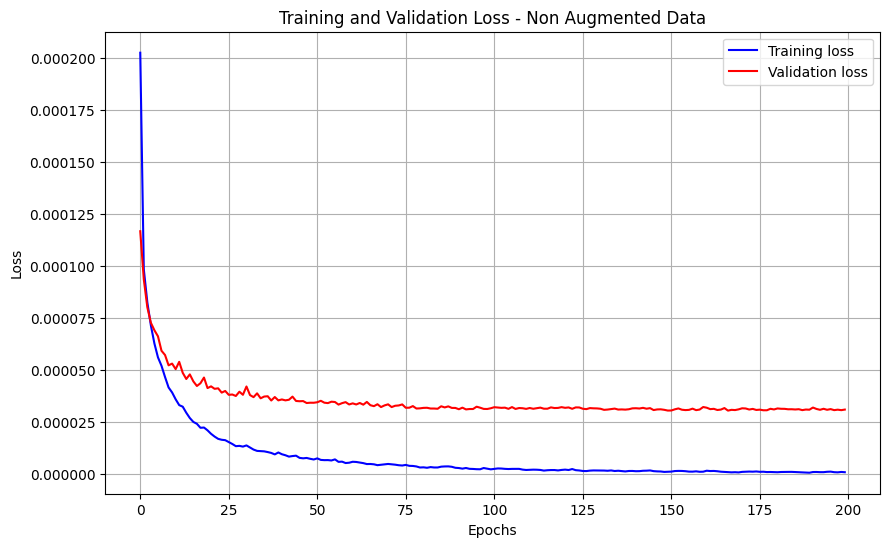

In [41]:
# Extraia os valores de loss do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(0, len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Non Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

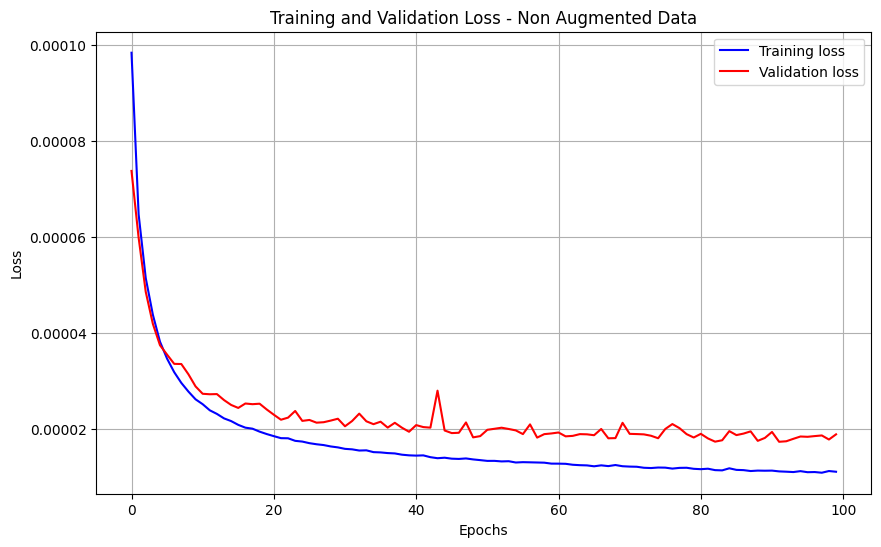

In [42]:
# Extraia os valores de loss do histórico
train_loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(0, len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Non Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
y_hat = model.predict(X_test)
y_hat_aug = model_aug.predict(X_test)

165/165 [==============================] - 1s 4ms/step


In [44]:
PredDF = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat,columns=['yh1','yh2','yh3'])],axis=1)

PredDF_aug = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat_aug,columns=['yh1','yh2','yh3'])],axis=1)

# Model Evaluation

In [45]:
PredDF.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.897212,-0.129360,-0.648243
y2,-0.111513,0.965233,0.230448
y3,-0.662203,0.215035,0.887406


In [46]:
PredDF_aug.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.912974,-0.144595,-0.708825
y2,-0.070048,0.970626,0.203250
y3,-0.682828,0.222154,0.903465


In [47]:
print('Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF['y1'], PredDF['yh1']))
print('')
print('')
# plt.scatter(PredDF['y1'], PredDF['yh1'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF['y2'], PredDF['yh2']))
print('')
print('')
# plt.scatter(PredDF['y2'], PredDF['yh2'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF['y3'], PredDF['yh3']))
print('')
print('')
# plt.scatter(PredDF['y3'], PredDF['yh3'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()


print('PredDF_aug: Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF_aug['y1'], PredDF_aug['yh1']))
print('')
print('')

print('PredDF_aug: Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF_aug['y2'], PredDF_aug['yh2']))
print('')

print('')
print('PredDF_aug: Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF_aug['y3'], PredDF_aug['yh3']))


Resultados Holdout Enn

0.804448743535078


Resultados Holdout Etn

0.9315571942398287


Resultados Holdout Ett

0.7853863774387289


PredDF_aug: Resultados Holdout Enn

0.8218148936591866


PredDF_aug: Resultados Holdout Etn

0.9395181097929203


PredDF_aug: Resultados Holdout Ett

0.795958712201686
